In [1]:
import numpy as np
runif=np.random.uniform
from scipy.special import gamma
import time as Time
from collections import deque
import matplotlib.pyplot as plt

# Definition of the function

## POD

In [2]:
def POD(task_arrival, service_times, N=20, d=3):
    #start with empty server
    server= [deque() for i in range(N)]
    #memory to know how many task in queue for each server
    memory= [0]*N
    system_time=[]
    overhead=0

    for time, serviceT in zip(task_arrival, service_times):

        #check if at current time there are task that are done,
        #if they are done, delete them from the queue
        for i in range(len(server)):
            if server[i]:
                #if its elaboration time is passed..
                if server[i][0][0]<time:
                    #how much time this task was in the system?
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    system_time.append(in_sys)
                    #delete it from the queue
                    server[i].popleft()
                    #if there is another task in the queue, update the time it 
                    #will be over, by adding the time it was in queue waiting
                    memory[i]-=1
                    if server[i]:
                        server[i][0][0]+=in_sys

        #POD, select 3 servers and check how many task in queue
        for i in range(d):
            #choise random server
            rnd_server=np.random.choice(list(range(N)))  
            #save to memory the len of the queue of the chosen server
            memory[rnd_server]=len(server[rnd_server]) 
            overhead+=2

        #save minimun length queue value
        min_value = min(memory)
        #save the index(es) of the server(s) with minimum length queue
        to_choose=[i for i, x in enumerate(memory) if x == min_value]
        #select randomly over servers with queue with min len over the d sever extracted
        selected_server=np.random.choice(to_choose)

        #update server, with new task saved as with time T the task will be over (current time+service time)
        #and time it entered the queue
        server[selected_server].append([serviceT+time,time])
        #update memory
        memory[selected_server]+=1

    return np.mean(system_time) , overhead/len(task_arrival)

## JBT-d

In [157]:
def JBTd(task_arrival, service_times, N=20, d=3, T=1):
    server= [deque() for i in range(N)]
    memory= [0]*N
    thousand=1
    system_time=[]
    overhead=0

    for time, serviceT in zip(task_arrival, service_times):

        for i in range(len(server)):
            if server[i]:
                if server[i][0][0]<time:
                    #how much time this task was in the system
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    server[i].popleft()
                    memory[i]-=1
                    system_time.append(in_sys)
                    if server[i]:
                        server[i][0][0]+=in_sys

        #check if 1000 time units passed
        if time/1000>thousand:
            #update threshold
            new_T=[]
            for i in range(d):
                #choose random server
                rnd_server=np.random.choice(list(range(N)))  
                #save to possible new threshold the len of queue of selected server
                new_T.append(len(server[rnd_server]))
            #save minimun length queue value as new T
            T = min(new_T)
            thousand+=1

        #select a random server over the ones with queue<T
        to_choose=[i for i in range(len(memory)) if memory[i]<=T]
        overhead+=len(to_choose)

        if to_choose:
            selected_server=np.random.choice(to_choose)
        else:
            selected_server=np.random.choice(list(range(N)))

        #update server, with new task saved as with time T the task will be over (current time+service time)
        server[selected_server].append([serviceT+time,time])
        memory[selected_server]+=1

    return np.mean(system_time) , overhead/len(task_arrival)

## JSQ

In [4]:
def JSQ(task_arrival, service_times, N=20):
#     N=20
    server= [deque() for i in range(N)]
    memory= [0]*N
    system_time=[]
    overhead=0

    for time, serviceT in zip(task_arrival, service_times):

        for i in range(len(server)):
            if server[i]:
                if server[i][0][0]<time:
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    server[i].popleft()
                    system_time.append(in_sys)
                    if server[i]:
                        server[i][0][0]+=in_sys

        for i in range(N): 
            #save to memory the len of the queue of the chosen server
            memory[i]=len(server[i]) 
            overhead+=2

        #save minimun length queue value
        min_value = min(memory)
        #save the index(es) of the server(s) with minimum length queue
        to_choose=[i for i, x in enumerate(memory) if x == min_value]
        #select randomly over servers with queue with min len over the d sever extracted
        selected_server=np.random.choice(to_choose)

        server[selected_server].append((serviceT+time,time))
        memory[selected_server]+=1
        
    return np.mean(system_time), overhead/len(service_times)

# Generate arrivals and processing time and simulate over them

In [5]:
T0=1 #arrival time    
Ymed=10 #average Y
q=3/5 #prob q
ET=T0+(1-q)*Ymed  #average time arrival
ET2=T0**2+(1-q)*(2*Ymed**2+2*T0*Ymed)      #variance of time arrival
CT=np.sqrt(ET2-ET**2)/ET
alfa=1/2
N=20 #servers
jbtdpoints=[]
jsqpoints=[]
podpoints=[]

rhovalues=np.linspace(0.88,0.99,100)
betavalues=[i*N*ET/gamma(1+(1/alfa)) for i in rhovalues]
EXvalues=[i*gamma(1+(1/alfa)) for i in betavalues]

for i in range(len(rhovalues)):
    ntry=1000 #task to generate
    n=10000
    mTv=[]
    mXv=[]
    rhov=[]

    for k in range(ntry):
        v=np.round(q-runif(0,1,n))  #random vector
        Tv=T0-(1-v)*np.log(runif(0,1,n))*Ymed  #vector of generated arrival times
        mT=np.mean(Tv) #its mean
        mTv.append(mT)  # save to the vector
        EX=EXvalues[i]   #processing time expected value

        #weibull distro parameters
        beta=EX/gamma(1+1/alfa)
        EX2=beta**2*gamma(1+2/alfa)
        #generate vector of processing time 
        Xv=np.maximum(1,np.minimum(100*EX, np.round(beta*(-np.log(runif(0,1,n)))**(1/alfa))))

        #compute metrics on the processing times
        mX=np.mean(Xv)
        mXv.append(mX)

        #utilization coeff
        #N server
        rho=EX/(N*ET)
        rhov.append(rho)
    
    #let's do 5 simulation for each model and save the average mean delay and 
    jbtdtimes=[]
    podtimes=[]
    jsqtimes=[]
    for k in range(5):
        jbtdtimes.append(JBTd(np.cumsum(mTv),mXv))
        podtimes.append(POD(np.cumsum(mTv),mXv))
        jsqtimes.append(JSQ(np.cumsum(mTv),mXv))
    #save average mean delay for this rho    
    jbtdpoints.append((np.mean([i[0] for i in jbtdtimes]), np.mean([i[1] for i in jbtdtimes])))
    podpoints.append((np.mean([i[0] for i in podtimes]), np.mean([i[1] for i in podtimes])))
    jsqpoints.append((np.mean([i[0] for i in jsqtimes]), np.mean([i[1] for i in jsqtimes])))

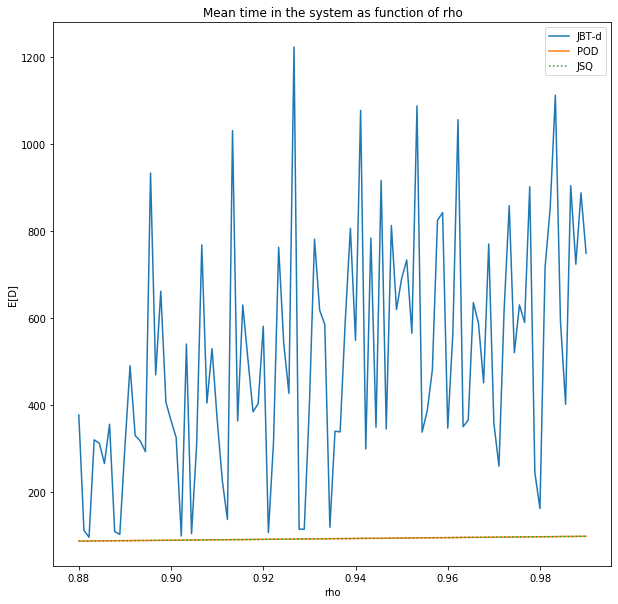

In [6]:
plt.figure(figsize=(10,10))
plt.plot(rhovalues,[i[0] for i in jbtdpoints], label='JBT-d')
plt.plot(rhovalues, [i[0] for i in podpoints], label='POD')
plt.plot(rhovalues, [i[0] for i in jsqpoints], label='JSQ', ls=':')
plt.title('Mean time in the system as function of rho')
plt.xlabel('rho')
plt.legend()
plt.ylabel('E[D]')
plt.show()

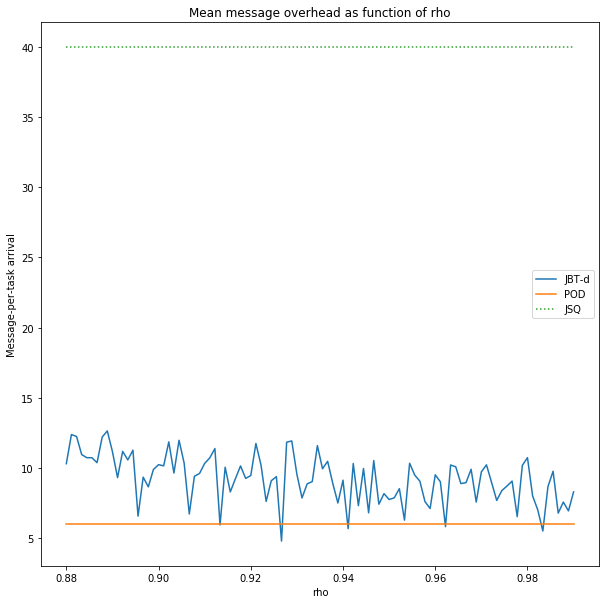

In [7]:
plt.figure(figsize=(10,10))
plt.plot(rhovalues,[i[1] for i in jbtdpoints], label='JBT-d')
plt.plot(rhovalues, [i[1] for i in podpoints], label='POD')
plt.plot(rhovalues, [i[1] for i in jsqpoints], label='JSQ', ls=':')
plt.title('Mean message overhead as function of rho')
plt.xlabel('rho')
plt.legend()
plt.ylabel('Message-per-task arrival')
plt.show()

# ignore what's below

# My function

In [8]:
def my_LB(task_arrival, service_times, N=20):
#     N=20
    server= [deque() for i in range(N)]
    memory= [0]*N
#     task_arrival=np.cumsum(mTv)
#     service_times=mXv
    system_time=[]
    

    for time, serviceT in zip(task_arrival, service_times):

        for i in range(len(server)):
            if server[i]:
                if server[i][0][0]<time:
                    in_sys=abs(server[i][0][1]-server[i][0][0])
                    server[i].popleft()
                    system_time.append(in_sys)
                    if server[i]:
                        server[i][0][0]+=in_sys

        for i in range(N): 
            #save to memory the len of the queue of the chosen server
            memory[i]=len(server[i]) 

        #save minimun length queue value
        min_value = min(memory)
        #save the index(es) of the server(s) with minimum length queue
        to_choose=[i for i, x in enumerate(memory) if x == min_value]
        #select randomly over servers with queue with min len over the d sever extracted
        selected_server=np.random.choice(to_choose)

        server[selected_server].append((serviceT+time,time))
        memory[selected_server]+=1
        
    return np.mean(system_time)

In [176]:
JBTd(np.cumsum(mTv),mXv)

(109.16329878787877, 10.952)

In [10]:
[deque([[142.94377545727684, 39.98427545727683]]), deque([[168.92837101450237, 69.98997101450237]]), deque([]), deque([]), deque([[109.66009590556166, 10.177595905561653]]), deque([[180.41975466915335, 79.89895466915337]]), deque([]), deque([]), deque([]), deque([]), deque([[157.2528356251665, 59.982935625166505]]), deque([]), deque([[149.56666837191275, 49.97616837191275]]), deque([]), deque([]), deque([]), deque([[187.88504722044155, 89.85834722044154]]), deque([[118.46479537273703, 20.05039537273703]]), deque([[201.79999150566388, 99.87259150566388]]), deque([[125.90781064770653, 29.963610647706528]])]==[deque([[142.94377545727684, 39.98427545727683]]), deque([[168.92837101450237, 69.98997101450237]]), deque([]), deque([]), deque([]), deque([[180.41975466915335, 79.89895466915337]]), deque([]), deque([]), deque([]), deque([]), deque([[157.2528356251665, 59.982935625166505]]), deque([]), deque([[149.56666837191275, 49.97616837191275]]), deque([]), deque([]), deque([]), deque([[187.88504722044155, 89.85834722044154]]), deque([[118.46479537273703, 20.05039537273703]]), deque([[201.79999150566388, 99.87259150566388]]), deque([[125.90781064770653, 29.963610647706528]])]


False